# Login

In [1]:
%matplotlib notebook
import os
import numpy as np
import matplotlib.pyplot as plt
import qulab
from qulab.tools.wavedata import *

In [2]:
#print(qulab.admin.get_database())
#qulab.admin.get_collection_info()
#qulab.admin.drop_collection(database='ten_qubits_measurement',
#                            collection=['application',])
qulab.admin.set_database('qubit_measurement')

The recent database is "qubit_measurement".
The following databases are already exist:
['admin', 'config', 'local', 'qubit_measurement', 'qubit_measurement_test']
Your recent selected database already is "qubit_measurement".


In [3]:
#qulab.admin.register()

In [4]:
qulab.login('liuqichun','123456')

# data process

## 3D spectrum

In [ ]:
qulab.query('auto_meas.three_dim_spectroscopy').display()

In [ ]:
fig = plt.figure()
f_sweet = 4.152
bias_period = 650
bias_center = 143

#record = qulab.query('auto_meas.three_dim_spectroscopy')[0]
# 绘制三维能谱图
x, y, amp = record.data
amp = np.array(amp).T
amp[amp<0] = 0.6
ax = fig.add_subplot(121)
a = ax.imshow(amp[0], extent=((min(y)*1000-bias_center)/bias_period, 
                              (max(y)*1000-bias_center)/bias_period, 
                              min(x)/1e9, max(x)/1e9),
              aspect='auto', origin='lower', interpolation='nearest')
ax.set_ylabel('freq(GHz)')
ax.set_xlabel('bias(phi_0)')
ax.set_title('Q10_spectrum_sweep_bias',fontsize=15)

# 计算qubit频率随bias的变化
bias_list = np.linspace(-0.06,0.06,25)
freq_list = f_sweet*(np.cos(bias_list*np.pi)+1.0)/2.0
ax.plot(bias_list,freq_list,'b-')
ax.plot([-0.032,],[f_sweet*(np.cos(-0.032*np.pi)+1.0)/2.0,],'r<')
ax.text(0,4.13,'working point:',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(0,4.125,'bias: 0.0387',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(0,4.12,'freq: 4.142GHz',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")

# 计算d_f/d_b
ax1 = fig.add_subplot(122)
d_freq_list = -f_sweet*np.sin(bias_list*np.pi)/2.0
ax1.plot(bias_list,d_freq_list,'b-')
ax1.plot([-0.032,],[-f_sweet*np.sin(-0.032*np.pi)/2.0,],'r<')
ax1.set_title('Q10_delta_f/delta_bias',fontsize=15)
ax1.text(0,0.4,'working point:',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax1.text(0,0.3,'bias: -0.035',fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")
ax1.text(0,0.2,'d_f/d_b: '+str(round(-f_sweet*np.sin(-0.032*np.pi)/2.0,5)),fontsize=10,
        verticalalignment="center",
        horizontalalignment="center")

## RBM line

In [ ]:
qulab.query('auto_meas.rbm_line').display()

In [ ]:
from qulab.tools.datafit import *
from qulab.tools.fileprocess._fileprocess import *

# get record result
record = qulab.query('auto_meas.rbm_line')[3]
# save record result to txt file and plot
path = os.path.join('E:/qubit_measurent_20200108/meas_result','RBM_line','Q9_reference_line.txt')
record2txt(record=record, txt_path=path, png=True, fig_title='Q9_reference_line')

ax = plt.gca()
fit = RBM_Fit((record.data[0],record.data[1]), d=2, p0=[1,0.5,0.99])
fit.plot()

ax.set_title('Q9_reference_line',fontsize=25)
ax.set_xlabel('Cliffords num')
ax.set_ylabel('Fidelity')
ax.text(100,0.9,'p_ref='+str(round(fit.p,4))
        +'$_{%.4f}^{%.4f}$'%(fit.p_error,fit.p_error),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(100,0.85,'F_ref='+str(round(1-(1-fit.F)/1.875,4))
        +'$_{%.4f}^{%.4f}$'%(fit.F_error/1.875,fit.F_error/1.875),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

In [ ]:
from qulab.tools.datafit import *
from qulab.tools.fileprocess._fileprocess import *

p_ref = 0.9891
# get record result
record = qulab.query('auto_meas.rbm_line')[4]
# save record result to txt file and plot
path = os.path.join('E:/qubit_measurent_20200108/meas_result','RBM_line','Q9_X_gate_line.txt')
record2txt(record=record, txt_path=path, png=True, fig_title='Q9_X_gate_line')

ax = plt.gca()
fit = RBM_Fit((record.data[0],record.data[1]), d=2, p0=[0.5,0.5,0.99])
fit.plot()

ax.set_title('Q9_X_gate_line',fontsize=25)
ax.set_xlabel('Cliffords num')
ax.set_ylabel('Fidelity')
ax.text(150,0.9,'p_X='+str(round(fit.p,4))
        +'$_{%.4f}^{%.4f}$'%(fit.p_error,fit.p_error),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(150,0.85,'Fidelity_X='+str(round((1+fit.p/p_ref)/2,4))
        +'$_{%.4f}^{%.4f}$'%(fit.F_error,fit.F_error),fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

## RTO line

In [ ]:
from qulab.tools.datafit import *
from scipy.fftpack import fft,ifft
sRate = 100/(11*36)

# 取原始数据
#data=qulab.query('auto_meas.rto_line')[1].data
# 修正采集卡产生的错误数据
data_p = np.array(data[1])
data_p[data_p<0] = 835000
# 去除测试设置的偏置频率，并做单位转化
data_p = (data_p-np.mean(data_p))/1e6 #原始数据单位为 Hz

# 做fft
fft_data = fft(data_p)/len(data_p)
# 获取能量谱PSD
index = int((len(fft_data)+1)/2)
# 获取和fft_data对应的真实频谱频率
x_1 = np.array([n for n in range(index)])
if len(fft_data)%2==0:
    x_2 = np.array([n for n in range(index)])+1
    x_2 = -x_2[::-1]
else:
    x_2 = np.array([n for n in range(index-1)])+1
    x_2 = -x_2[::-1]
freq = np.append(x_1,x_2)*sRate/len(data_p)
# 滑动窗口平滑
freq = freq[15:4985]
fft_data_p = np.convolve(abs(fft_data[1:5000]), np.ones((30,))/30, mode='valid')


# 转化为磁通的噪声谱
freq_bias_ratio = -0.28504*1000 #乘以1000是转为 MHz 单位
bias_noise = 1e12*fft_data_p/(freq_bias_ratio*freq_bias_ratio)


# 进行拟合
class RTO_Fit(BaseFit):
    '''Simple Linear Fit'''
    def _fitfunc(self,t,alpha,A,B):
        y= A/t**alpha + B
        return y
    @property
    def alpha(self):
        alpha,A,B=self._popt
        return alpha
    @property
    def A(self):
        alpha,A,B=self._popt
        return A
    @property
    def B(self):
        alpha,A,B=self._popt
        return B
# 拟合
fit = RTO_Fit((freq,bias_noise),p0=[1,10,3000])

# 画图
fig=plt.figure()
ax = fig.add_subplot(111)
ax.plot(freq,bias_noise,'b-')
fit.plot()
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel('Noise PSD ($\mu\phi_{0}^{2}/Hz$)')
ax.set_xlabel('Frequency(Hz)')
ax.set_title('RTO noise psd line',fontsize=20)

ax.text(2e-2,2.5e4,'1/f noise magnitude '+'$S^{*}$='+str(round(fit.A,4)),
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(2e-2,2.0e4,'1/f noise slope '+'a='+str(round(fit.alpha,4)),
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")
ax.text(2e-2,1.5e4,'white noise = '+str(round(fit.B,4)),
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

ax.text(1e-3,4e3,'$\mathrm{S=A/f^a+B}$',
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

## N qubit MLE

In [ ]:
from qulab.tools.QST_by_MLE._MLE import *

In [ ]:
data = qulab.query('auto_meas.N_qubit_state_prepare_and_QST')[0].data

In [ ]:
N_bit_mle = MLE()

two_bit_mle.meas_data = data[0]
two_bit_mle.max_evals = 1500
two_bit_mle.matlab_file_dir = 'E:/2.code/Quantum_Lab/qulab/tools/QST_by_MLE'

two_bit_mle.do_MLE()
density_matrix=two_bit_mle.get_density_mstrix()

# 绘制三维图
X=np.arange(0, 2**2, step=1)-0.5
Y=np.arange(0, 2**2, step=1)-0.5
Z=np.real(density_matrix)

xx, yy = np.meshgrid(X, Y)#网格化坐标
X, Y = xx.ravel(), yy.ravel()#矩阵扁平化
bottom = np.zeros_like(X)#设置柱状图的底端位值
Z = Z.ravel()#扁平化矩阵
width=height=0.75

#绘图设置
fig=plt.figure()
ax=fig.add_subplot(111, projection='3d')
ax.bar3d(X, Y, bottom, width, height, Z, shade=True, color='lightskyblue',alpha=1.0)
#ax.set_xticklabels(['','000','001','010','011','100','101','110','111'])
#ax.set_yticklabels(['','000','001','010','011','100','101','110','111'])

## data fit

<IPython.core.display.Javascript object>


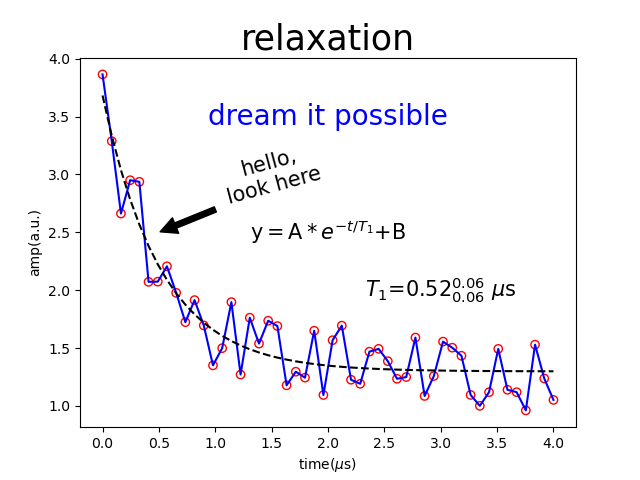

c:\users\lqc\appdata\local\programs\python\python37\lib\site-packages\qulab\tools\datafit\_Fit.py:32: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
  ax.scatter(t, y, **scatter_kw)


Text(2, 2.5, '$\\mathrm{y=A*}$$e^{-t/T_1}$$\\mathrm{+B}$')

In [4]:
from qulab.tools.datafit import *

def func(t, A, B, T1):
    '''this an example: T1 fit function '''
    y=A*np.exp(-t/T1)+B
    return y
xdata = np.linspace(0, 4, 50)
y = func(xdata, 2.5, 1.3, 0.5)
np.random.seed(72)
y_noise = 0.2 * np.random.normal(size=xdata.size)
ydata = y + y_noise

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xdata, ydata, 'b-', label='data')

fit = T1_Fit((xdata,ydata))
fit.plot()

ax.set_title('relaxation',fontsize=25)
ax.set_xlabel('time($\mu$s)')
ax.set_ylabel('amp(a.u.)')

ax.annotate('hello,'+'\n'+'look here', xy=(0.5, 2.5), xytext=(1.5, 3), 
            fontsize=15,rotation=15,
            verticalalignment="center",
            horizontalalignment="center",
            arrowprops=dict(facecolor='black', shrink=0.02))

ax.text(2,3.5,'dream it possible',fontsize=20, color='b',
        verticalalignment="center",
        horizontalalignment="center")

ax.text(3,2,'$T_1$='+str(round(fit.T1,2))
        +'$_{%.2f}^{%.2f}$'%(fit.T1_error,fit.T1_error)
        +' $\mu$'+'s',fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

ax.text(2,2.5,'$\mathrm{y=A*}$'+'$e^{-t/T_1}$'+'$\mathrm{+B}$',
        fontsize=15,
        verticalalignment="center",
        horizontalalignment="center")

## modified by transfer_func H(w)

<IPython.core.display.Javascript object>


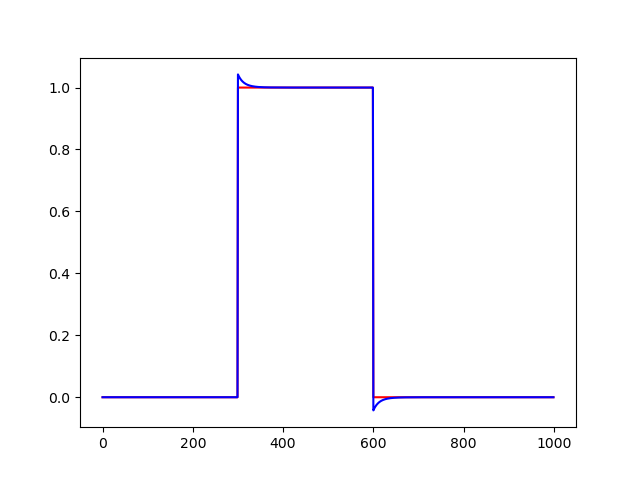

c:\users\lqc\appdata\local\programs\python\python37\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


In [5]:
import numpy as np
from qulab.tools.wavedata import *

pulse = Blank(width=300e-9,sRate=1e9)|DC(width=300e-9,sRate=1e9)
pulse = Wavedata.setLen(pulse,1e-6)

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.plot(pulse.data,'r')

transfer_func = lambda w: 1+1j*0.02*w/(1j*w+1e9/10)+1j*0.014*w/(1j*w+1e9/15)+1j*0.01*w/(1j*w+1e9/20)
pulse = pulse.transfer_wd(transfer_func)
ax1.plot(pulse.data,'b')

# record file process

## Data acquire

In [ ]:
## 数据获取
qulab.query('PNA.three_dim_S21_sweep_mag_bias').display()
print(qulab.query('PNA.three_dim_S21_sweep_mag_bias').count())

In [ ]:
## 数据删除
from qulab.tools.fileprocess import *
del_record(fullname='Rabi.rabi_line',index=[i for i in range(0)])

In [ ]:
## 查看数据库的集合
qulab.admin.get_collection_info(database='qulab')

In [ ]:
## 删除数据库的集合
#qulab.admin.drop_collection(database='qulab', collection=['driver','instrument',])

## data save

In [ ]:
## record存储为txt文件，同时保存图片
from qulab.tools.fileprocess import *
#print(qulab.query('PNA.three_dim_S21_sweep_mag_bias').display())
record2txt(record=qulab.query('PNA.three_dim_S21_sweep_mag_bias')[6], 
           txt_path='/Users/liuqichun/Desktop/3D_S21_sweep_bias.txt', 
           tag='for test', png=True)
record2txt(record=qulab.query('PNA.S21')[38], 
           txt_path='/Users/liuqichun/Desktop/S21.txt', 
           tag='for test', png=True)

In [ ]:
## 数据存储为‘.npz'文件
from qulab.tools.fileprocess._fileprocess import *
data = qulab.query('Rabi.three_dim_rabi')[9].data
tag = get_record_info(qulab.query('Rabi.three_dim_rabi')[9])
save(path='/Users/liuqichun/Desktop',
     name='for_test',
     x=data[0],
     y=data[1],
     z=data[2],1
     tag=tag)
save(name='for_test',
     x=data[0],
     y=data[1],
     z=data[2],
     tag=tag)
save(path='/Users/liuqichun/Desktop',
     name='for_test1.npz',
     record=qulab.query('Rabi.three_dim_rabi')[9])

In [ ]:
## 读取’.npz‘文件绘图
dataout=np.load('tempdata/20190725/for_test.npz')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(dataout['z'], extent=(min(dataout['x'])*1e9, max(dataout['x'])*1e9, 
                                min(dataout['y']), max(dataout['y'])),
          aspect='auto', origin='lower', interpolation='nearest')
ax.set_xlabel('time (ns)')
ax.set_ylabel('power (dBm)')

In [ ]:
# 绘制三维图
from mpl_toolkits.mplot3d import Axes3D
freq, bias, amp, phase = qulab.query('PNA.three_dim_S21_sweep_mag_bias')[6].data
freq = np.tile(freq, (len(bias),1))
bias = np.tile(bias, (len(freq[0]),1)).T

fig = plt.figure()
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
ax1.plot_surface(bias*1e3,freq/1e9,amp,rstride=1, cstride=1, cmap='rainbow')
ax1.set_xlabel('bias current (mA)')
ax1.set_ylabel('frequency (GHz)')
ax1.set_zlabel('amplitude (dB)')
ax2.plot_surface(bias*1e3,freq/1e9,phase,rstride=1, cstride=1, cmap='rainbow')
ax2.set_xlabel('bias current (mA)')
ax2.set_ylabel('frequency (GHz)')
ax2.set_zlabel('phase (degree)')

# examples still need debug

## x6 example

In [ ]:
x6 = qulab.open_resource('X6')

In [ ]:
config=dict(ref_clk_source = 'INTERNAL',
                           sample_clk_source = 'INTERNAL',
                           trig_source = 'MUNUAL',
                           adc_inchannel = [1,1],
                           n=2048,
                           repeats=40,
                           sampleRate=1e9,
                           dac_outchannel = [1,1,1,1],
                           dac_sRate=0.5e9)
x6.set_para(**config)
x6.trig_n = 100

In [ ]:
x6.get_temperature()

In [ ]:
from qulab.tools.wavedata import *
pulse = Blank(width=20e-9,sRate=0.5e9)|CosPulse(width=0.2e-6,sRate=0.5e9)|DC(width=0.2e-6,sRate=0.5e9)*-1
pulse = Wavedata.setLen(pulse,8000e-9)
wavedata = np.hstack(np.array([pulse.data,pulse.data,pulse.data,pulse.data]).T)

In [ ]:
x6.write_dac_wavedata(wavedata)

In [ ]:
ch_A,ch_B = x6.acquire_adc_data()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.mean(ch_A[2:,:],axis=0),'r-*')
ax.plot(np.mean(ch_B[2:,:],axis=0),'b-<')

## molecular energy simulation

In [5]:
from qulab.tools.gate_sequence_simulator._GSS import *
simulator = GSS()

In [6]:
gate_list = ['X0',['X2n0','Y2p1'],'Y2n0','CP1_0','Y2p0','Z0:0.0','Y2n0','CP1_0','Y2p0',['X2p0','Y2n1'],['I0','I1']]

In [7]:
simulator.gate_list = gate_list

<IPython.core.display.Javascript object>


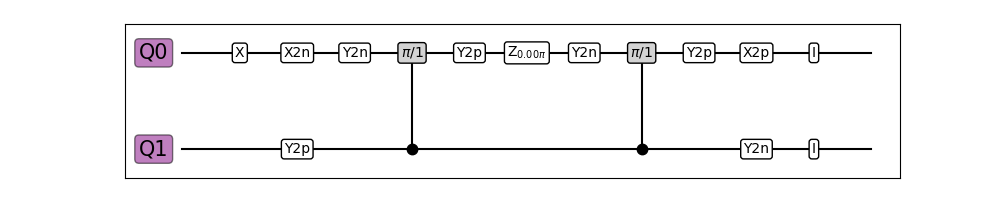

In [8]:
simulator.gate_list_figure()

In [35]:
Z0I1_pro = []
I0Z1_pro = []
Z0Z1_pro = []
Y0Y1_pro = []
X0X1_pro = []
for theta in np.linspace(-1,1,51):
    gate_list[5] = 'Z0:'+str(theta)
    
    gate_list[-1] = ['I0','I1']
    simulator.gate_list = gate_list
    pro = simulator.get_final_probability()
    Z0I1_pro.append(pro[0]-pro[1]+pro[2]-pro[3])
    I0Z1_pro.append(pro[0]+pro[1]-pro[2]-pro[3])
    Z0Z1_pro.append(pro[0]-pro[1]-pro[2]+pro[3])
    
    gate_list[-1] = ['X2n0','X2n1']
    simulator.gate_list = gate_list
    pro = simulator.get_final_probability()
    Y0Y1_pro.append(pro[0]-pro[1]-pro[2]+pro[3])
    
    gate_list[-1] = ['Y2n0','Y2n1']
    simulator.gate_list = gate_list
    pro = simulator.get_final_probability()
    X0X1_pro.append(pro[0]-pro[1]-pro[2]+pro[3])

<IPython.core.display.Javascript object>


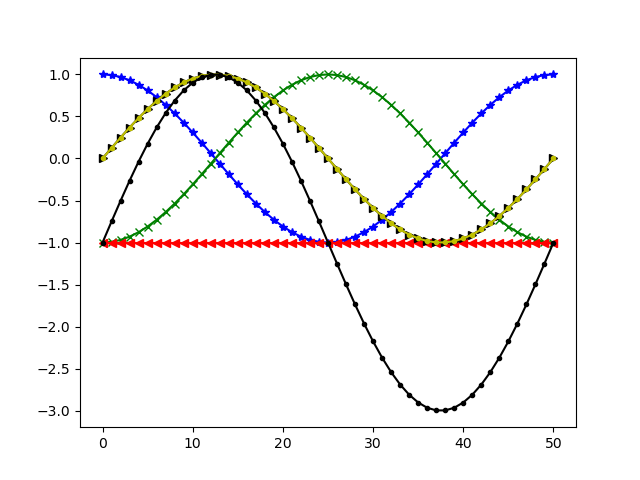

In [36]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(Z0I1_pro,'b*-')
ax.plot(I0Z1_pro,'gx-')
ax.plot(Z0Z1_pro,'r<-')
ax.plot(Y0Y1_pro,'k>-')
ax.plot(X0X1_pro,'y.-')
ax.plot(np.array(Z0I1_pro)+np.array(I0Z1_pro)+np.array(Z0Z1_pro)+np.array(Y0Y1_pro)+np.array(X0X1_pro),'k.-')

In [331]:
import numpy as np

class GA(gradient_approximation):
    def __init__(self):
        super(GA,self).__init__()
        
    def get_function_result(self,variable,**key):
        return (2*variable[0]+1)**2+(variable[1]-0.5)**2+np.random.rand()*0.01

GA_test = GA()
GA_test.step_num = 100
GA_test.variable_init = np.array([0,2])
GA_test.variable_delta = np.array([0.99,0.99])

GA_test.do_approximation()
variable_list = GA_test.variable_list
function_result_list = np.array(GA_test.function_result_list)

<IPython.core.display.Javascript object>


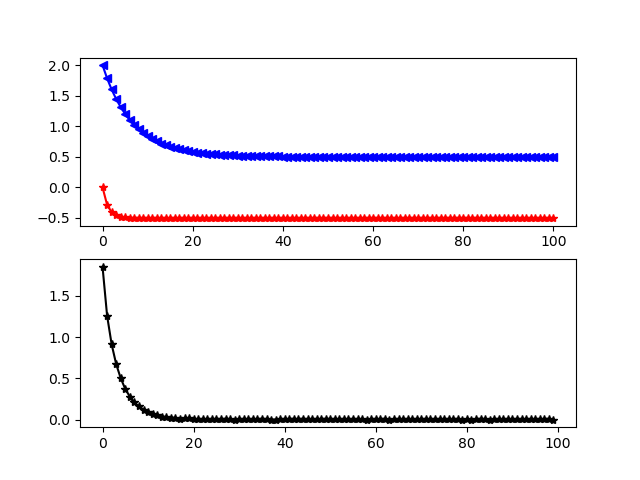

In [332]:
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot(np.array(variable_list).T[0],'r*-')
ax1.plot(np.array(variable_list).T[1],'b<-')
#ax2.plot(np.array(function_result_list).T[0],'r*-')
#ax2.plot(np.array(function_result_list).T[1],'b*-')
ax2.plot(function_result_list,'k*-')

<IPython.core.display.Javascript object>


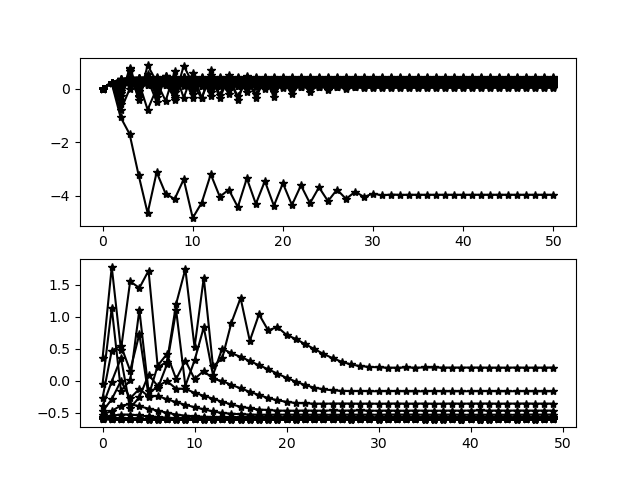

In [333]:
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator,jordan_wigner
from qulab.tools.gate_sequence_simulator._GSS import *

class GA(gradient_approximation):
    def get_function_result(self,variable,**key):
        g = key['g']
        simulator = GSS()
        gate_list = ['X0',['X2n0','Y2p1'],'Y2n0','CP1_0','Y2p0','Z0:0.0','Y2n0','CP1_0','Y2p0',['X2p0','Y2n1'],['I0','I1']]
        gate_list[5] = 'Z0:'+str(variable[0])
        gate_list[-1] = ['I0','I1']
        simulator.gate_list = gate_list
        pro = simulator.get_final_probability()
        Z0I1_pro = pro[0]-pro[1]+pro[2]-pro[3]
        I0Z1_pro = pro[0]+pro[1]-pro[2]-pro[3]
        Z0Z1_pro = pro[0]-pro[1]-pro[2]+pro[3]

        gate_list[-1] = ['X2n0','X2n1']
        simulator.gate_list = gate_list
        pro = simulator.get_final_probability()
        Y0Y1_pro = pro[0]-pro[1]-pro[2]+pro[3]

        gate_list[-1] = ['Y2n0','Y2n1']
        simulator.gate_list = gate_list
        pro = simulator.get_final_probability()
        X0X1_pro = pro[0]-pro[1]-pro[2]+pro[3]
        pro_array = np.array([Z0I1_pro,I0Z1_pro,Z0Z1_pro,Y0Y1_pro,X0X1_pro]).T
        energy = np.dot(g[1:],pro_array)+g[0]
        return energy+np.random.rand()*0.005


fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

E_to_R = []
for bond_length in np.linspace(0.3,2.3,21):
    # Set molecule parameters.
    basis = 'sto-3g'
    multiplicity = 1
    description = str(round(bond_length,2))
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(geometry, basis, multiplicity, description=description)
    # Load data.
    molecule.load()
    h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
    
    # g_list
    h_list = []
    h_temp = str(h2_qubit_hamiltonian).split('\n')
    idx = 0
    for temp in h_temp:
        h_list.append(float(temp[1:15]))
        idx = idx+1
    g_list = np.zeros(6)
    g_list[0] = h_list[0]+h_list[9]+h_list[10]+h_list[12]
    g_list[1] = h_list[5]+h_list[6]+h_list[7]
    g_list[2] = h_list[11]+h_list[13]+h_list[14]
    g_list[3] = h_list[8]
    g_list[4] = h_list[2]
    g_list[5] = h_list[3]
    g_list = np.array(g_list)
    
    GA_test = GA()
    GA_test.step_num = 50
    GA_test.variable_init = [0]
    GA_test.variable_delta = [0.9]
    GA_test.do_approximation(g=g_list)
    
    theta_list = GA_test.variable_list
    E_list = np.array(GA_test.function_result_list)
    E_to_R.append(np.mean(E_list[-10:]))
    
    ax1.plot(theta_list,'k*-')
    ax2.plot(E_list,'k*-')
    plt.show()

<IPython.core.display.Javascript object>


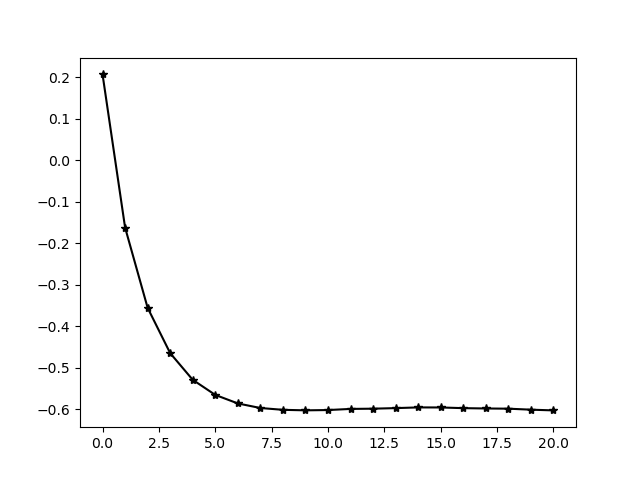

In [334]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(E_to_R,'k*-')

In [17]:
from openfermion.hamiltonians import MolecularData

# Set parameters to make a simple molecule.
diatomic_bond_length = .7414
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., diatomic_bond_length))]
basis = 'sto-3g'
multiplicity = 1
charge = 0
description = str(diatomic_bond_length)

# Make molecule and print out a few interesting facts about it.
molecule = MolecularData(geometry, basis, multiplicity,
                         charge, description)
print('Molecule has automatically generated name {}'.format(
    molecule.name))
print('Information about this molecule would be saved at:\n{}\n'.format(
    molecule.filename))
print('This molecule has {} atoms and {} electrons.'.format(
    molecule.n_atoms, molecule.n_electrons))
for atom, atomic_number in zip(molecule.atoms, molecule.protons):
    print('Contains {} atom, which has {} protons.'.format(
        atom, atomic_number))

Molecule has automatically generated name H2_sto-3g_singlet_0.7414
Information about this molecule would be saved at:
c:\users\lqc\appdata\local\programs\python\python36\lib\site-packages\openfermion\data\H2_sto-3g_singlet_0.7414

This molecule has 2 atoms and 2 electrons.
Contains H atom, which has 1 protons.
Contains H atom, which has 1 protons.


In [9]:
from openfermion.transforms import get_fermion_operator,jordan_wigner

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length = 0.3
description = str(round(bond_length,2))
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
molecule = MolecularData(geometry, basis, multiplicity, description=description)

# Load data.
molecule.load()
h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
print(h2_qubit_hamiltonian)

(1.3007238506669039+0j) [] +
(-0.04020462981189694+0j) [X0 X1 Y2 Y3] +
(0.04020462981189694+0j) [X0 Y1 Y2 X3] +
(0.04020462981189694+0j) [Y0 X1 X2 Y3] +
(-0.04020462981189694+0j) [Y0 Y1 X2 X3] +
(0.258691542697232+0j) [Z0] +
(0.1880046389486194+0j) [Z0 Z1] +
(0.14527088789771972+0j) [Z0 Z2] +
(0.18547551770961668+0j) [Z0 Z3] +
(0.258691542697232+0j) [Z1] +
(0.18547551770961668+0j) [Z1 Z2] +
(0.14527088789771972+0j) [Z1 Z3] +
(-0.5499573655735537+0j) [Z2] +
(0.19623437355578074+0j) [Z2 Z3] +
(-0.5499573655735537+0j) [Z3]


In [21]:
import numpy as np

h_list = []
h_temp = str(h2_qubit_hamiltonian).split('\n')
idx = 0
for temp in h_temp:
    h_list.append(float(temp[1:15]))
    idx = idx+1
print(h_list)

g_list = np.zeros(6)
g_list[0] = h_list[0]+h_list[9]+h_list[10]+h_list[12]
g_list[1] = h_list[5]+h_list[6]+h_list[7]
g_list[2] = h_list[11]+h_list[13]+h_list[14]
g_list[3] = h_list[8]
g_list[4] = h_list[2]
g_list[5] = h_list[3]
print(g_list)

[1.300723850666, -0.04020462981, 0.040204629811, 0.040204629811, -0.04020462981, 0.258691542697, 0.188004638948, 0.145270887897, 0.185475517709, 0.258691542697, 0.185475517709, 0.145270887897, -0.54995736557, 0.196234373555, -0.54995736557]
[ 1.15472892  0.6321717  -0.16824747  0.14527089  0.04020463  0.04020463]


0.3
(1.3007238506669039+0j) [] +
(-0.04020462981189694+0j) [X0 X1 Y2 Y3] +
(0.04020462981189694+0j) [X0 Y1 Y2 X3] +
(0.04020462981189694+0j) [Y0 X1 X2 Y3] +
(-0.04020462981189694+0j) [Y0 Y1 X2 X3] +
(0.258691542697232+0j) [Z0] +
(0.1880046389486194+0j) [Z0 Z1] +
(0.14527088789771972+0j) [Z0 Z2] +
(0.18547551770961668+0j) [Z0 Z3] +
(0.258691542697232+0j) [Z1] +
(0.18547551770961668+0j) [Z1 Z2] +
(0.14527088789771972+0j) [Z1 Z3] +
(-0.5499573655735537+0j) [Z2] +
(0.19623437355578074+0j) [Z2 Z3] +
(-0.5499573655735537+0j) [Z3]
0.4
(0.7407724940116754+0j) [] +
(-0.041128856023498556+0j) [X0 X1 Y2 Y3] +
(0.041128856023498556+0j) [X0 Y1 Y2 X3] +
(0.041128856023498556+0j) [Y0 X1 X2 Y3] +
(-0.041128856023498556+0j) [Y0 Y1 X2 X3] +
(0.23528824284103544+0j) [Z0] +
(0.18421983815174378+0j) [Z0 Z1] +
(0.14020450296633868+0j) [Z0 Z2] +
(0.18133335898983727+0j) [Z0 Z3] +
(0.23528824284103542+0j) [Z1] +
(0.18133335898983727+0j) [Z1 Z2] +
(0.14020450296633868+0j) [Z1 Z3] +
(-0.45353118471995524+0j) [Z

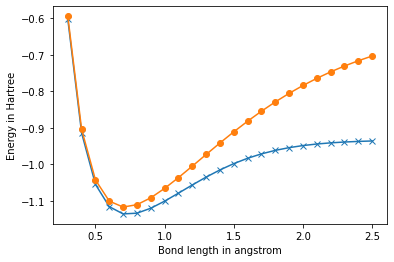

In [6]:
from openfermion.transforms import get_fermion_operator,jordan_wigner

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length_interval = 0.1
n_points = 25

# Generate molecule at different bond lengths.
hf_energies = []
fci_energies = []
bond_lengths = []
for point in range(3, n_points + 1):
    bond_length = bond_length_interval * point
    bond_lengths += [bond_length]
    description = str(round(bond_length,2))
    print(description)
    geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
    molecule = MolecularData(
        geometry, basis, multiplicity, description=description)
    
    # Load data.
    molecule.load()
    h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian()))
    print(h2_qubit_hamiltonian)

    """
    # Print out some results of calculation.
    print('\nAt bond length of {} angstrom, molecular hydrogen has:'.format(
        bond_length))
    print('Hartree-Fock energy of {} Hartree.'.format(molecule.hf_energy))
    print('MP2 energy of {} Hartree.'.format(molecule.mp2_energy))
    print('FCI energy of {} Hartree.'.format(molecule.fci_energy))
    print('Nuclear repulsion energy between protons is {} Hartree.'.format(
        molecule.nuclear_repulsion))
    for orbital in range(molecule.n_orbitals):
        print('Spatial orbital {} has energy of {} Hartree.'.format(
            orbital, molecule.orbital_energies[orbital]))
    """
    hf_energies += [molecule.hf_energy]
    fci_energies += [molecule.fci_energy]

# Plot.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(0)
plt.plot(bond_lengths, fci_energies, 'x-')
plt.plot(bond_lengths, hf_energies, 'o-')
plt.ylabel('Energy in Hartree')
plt.xlabel('Bond length in angstrom')
plt.show()

In [1]:
from openfermion.hamiltonians import MolecularData
geometry = [['H',[0,0,0]],['H',[0,0,0.7414]]]
basis = 'sto−3g'
multiplicity = 1
charge = 0
h2_molecule = MolecularData(geometry,basis,multiplicity,charge)

In [52]:
import cirq
from cirq.contrib.svg import SVGCircuit
import openfermioncirq as ofc
from openfermion.transforms import get_fermion_operator,jordan_wigner

# Set molecule parameters.
basis = 'sto-3g'
multiplicity = 1
bond_length = 0.5
description = str(round(bond_length,2))
geometry = [('H', (0., 0., 0.)), ('H', (0., 0., bond_length))]
molecule = MolecularData(geometry, basis, multiplicity, description=description)

# Load data.
molecule.load()
hamiltonian = molecule.get_molecular_hamiltonian()

qubits = cirq.LineQubit.range(4)
circuit = cirq.Circuit(ofc.simulate_trotter(qubits,
                                              hamiltonian,
                                              time=1.0,
                                              n_steps=1,
                                              order=0,
                                              algorithm=ofc.trotter.LOW_RANK,
                                              omit_final_swaps=True))
cirq.merge_single_qubit_gates_into_phased_x_z(circuit)

test_circuit = cirq.Circuit()
test_circuit.append(cirq.H(qubits[0]))
test_circuit.append(cirq.CNOT(qubits[0],qubits[1]))
test_circuit.append(circuit)

# Initialize Simulator
s=cirq.Simulator()
print('Simulate the circuit:')
results=s.simulate(test_circuit)
print(results)

print(test_circuit[:10].to_text_diagram(use_unicode_characters=False))
print('########################')
print(test_circuit[10:20].to_text_diagram(use_unicode_characters=False))
print('########################')
print(test_circuit[20:30].to_text_diagram(use_unicode_characters=False))
print('########################')
print(test_circuit[30:40].to_text_diagram(use_unicode_characters=False))
print('########################')
print(test_circuit[40:].to_text_diagram(use_unicode_characters=False))

Simulate the circuit:
measurements: (no measurements)
output vector: 0.707|0000⟩ + (-0.353+0.601j)|0011⟩ + (0.102+0.06j)|1100⟩
0: ---H---@---Z^0.59-------------------------------PhISwap(0.25)--------------------------------------------@----------
          |                                        |                                                        |
1: -------X---Z^0.59------------PhISwap(0.25)------PhISwap(0.25)^-1----------------------PhISwap(0.25)------@^-0.233---
                                |                                                        |
2: -----------Z^0.227-----------PhISwap(0.25)^-1----------------------PhISwap(0.25)------PhISwap(0.25)^-1--------------
                                                                      |
3: -----------Z^0.227-------------------------------------------------PhISwap(0.25)^-1---------------------------------
########################
0: ---swap--------------------------------@----------swap---Z^0.887--------------------------
 

In [2]:
from openfermionpsi4 import run_psi4
h2_molecule = run_psi4(h2_molecule,
                      run_mp2=True,
                      run_cisd=True,
                      run_ccsd=True,
                      run_fci=True)
two_electron_integrals = h2_molecule.two_body_integrals

UnicodeEncodeError: 'gbk' codec can't encode character '\u2212' in position 656: illegal multibyte sequence

In [3]:
from openfermion.transforms import get_fermion_operator,jordan_wigner
h2_molecule.get_molecular_hamiltonian()
#h2_qubit_hamiltonian = jordan_wigner(get_fermion_operator(h2_molecule.get_molecular_hamiltonian()))

MissingCalculationError: Missing integral calculation in c:\users\lqc\appdata\local\programs\python\python36\lib\site-packages\openfermion\data\H2_sto−3g_singlet, run before loading integrals.